# Ungraded Lab: Predicting Sunspots with Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week4/Labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

## Imports

In [1]:
import tensorflow as tf
from keras import Sequential, Input, layers, optimizers, losses, callbacks, backend, metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

2024-06-14 14:16:01.903007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """
    sns.set_style("whitegrid")

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:
        # Loop over the y elements
        for y_curr in y:
            # Plot the x and current y values
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        # Plot the x and y values
        plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [3]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-06-14 14:16:04--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4012:822::201b, 2607:f8b0:4012:823::201b, 2607:f8b0:4012:824::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4012:822::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.07s   

2024-06-14 14:16:05 (990 KB/s) - ‘Sunspots.csv’ saved [70827/70827]



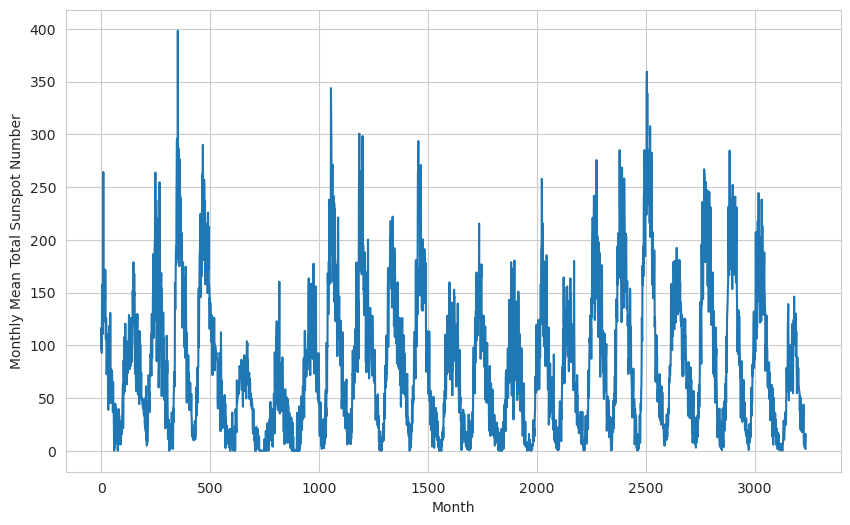

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [5]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.

In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-06-14 14:16:05.753341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1937 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [8]:
# Build the Model
model = Sequential([Input(shape=(window_size, 1)),
                    layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal'),
                    layers.LSTM(64, return_sequences=True),
                    layers.LSTM(64),
                    layers.Dense(30, activation="relu"),
                    layers.Dense(10, activation="relu"),
                    layers.Dense(1),
                    layers.Lambda(lambda x: x * 400)])

 # Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [9]:
# Get initial weights
init_weights = model.get_weights()

In [10]:
# Set the learning rate scheduler
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-06-14 14:16:07.186012: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 70.1753 - learning_rate: 1.0000e-08
Epoch 2/100
28/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.2107

2024-06-14 14:16:08.493117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:08.493151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.4438 - learning_rate: 1.1220e-08
Epoch 3/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.7062

2024-06-14 14:16:08.911453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 14:16:08.911476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.9870 - learning_rate: 1.2589e-08
Epoch 4/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.7966

2024-06-14 14:16:09.365653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:09.365684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.9124 - learning_rate: 1.4125e-08
Epoch 5/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.0049

2024-06-14 14:16:09.759458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:09.759482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.7741 - learning_rate: 1.5849e-08
Epoch 6/100
28/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.1120

2024-06-14 14:16:10.151165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:10.151185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.8157 - learning_rate: 1.7783e-08
Epoch 7/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.7587

2024-06-14 14:16:10.549208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:10.549238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.8272 - learning_rate: 1.9953e-08
Epoch 8/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.4258

2024-06-14 14:16:10.945838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:10.945858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.8532 - learning_rate: 2.2387e-08
Epoch 9/100
23/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.9914

2024-06-14 14:16:11.340335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:11.340357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.4148 - learning_rate: 2.5119e-08
Epoch 10/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.6857

2024-06-14 14:16:11.757093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:11.757116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.9232 - learning_rate: 2.8184e-08
Epoch 11/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.7333

2024-06-14 14:16:12.147450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:12.147472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.9962 - learning_rate: 3.1623e-08
Epoch 12/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.7388

2024-06-14 14:16:12.538250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:12.538281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.3079 - learning_rate: 3.5481e-08
Epoch 13/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.2670

2024-06-14 14:16:12.933988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:12.934017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.1517 - learning_rate: 3.9811e-08
Epoch 14/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.5405

2024-06-14 14:16:13.336124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:13.336167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.5753 - learning_rate: 4.4668e-08
Epoch 15/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.1377

2024-06-14 14:16:13.787023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:13.787043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.3295 - learning_rate: 5.0119e-08
Epoch 16/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.4133

2024-06-14 14:16:14.217283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:14.217307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.5798 - learning_rate: 5.6234e-08
Epoch 17/100
30/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.6790

2024-06-14 14:16:14.607905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:14.607926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.1079 - learning_rate: 6.3096e-08
Epoch 18/100
30/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0304

2024-06-14 14:16:14.997858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:14.997883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.4763 - learning_rate: 7.0795e-08
Epoch 19/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.0081

2024-06-14 14:16:15.386772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:15.386792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.8083 - learning_rate: 7.9433e-08
Epoch 20/100
28/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.7338

2024-06-14 14:16:15.782565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:15.782587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.3738 - learning_rate: 8.9125e-08
Epoch 21/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.7283

2024-06-14 14:16:16.199669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:16.199702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.6427 - learning_rate: 1.0000e-07
Epoch 22/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.4180

2024-06-14 14:16:16.668717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:16.668739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.2451 - learning_rate: 1.1220e-07
Epoch 23/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.0542

2024-06-14 14:16:17.124401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:17.124438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.0927 - learning_rate: 1.2589e-07
Epoch 24/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7635

2024-06-14 14:16:17.564983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:17.565012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.5693 - learning_rate: 1.4125e-07
Epoch 25/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.1145

2024-06-14 14:16:18.003282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:18.003309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.5422 - learning_rate: 1.5849e-07
Epoch 26/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.6117

2024-06-14 14:16:18.446594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:18.446619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.6396 - learning_rate: 1.7783e-07
Epoch 27/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.6048

2024-06-14 14:16:18.907421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:18.907445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.0973 - learning_rate: 1.9953e-07
Epoch 28/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3172

2024-06-14 14:16:19.408666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:19.408690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.9533 - learning_rate: 2.2387e-07
Epoch 29/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6759

2024-06-14 14:16:19.853472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:19.853507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.9618 - learning_rate: 2.5119e-07
Epoch 30/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.9583

2024-06-14 14:16:20.302718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:20.302741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.7418 - learning_rate: 2.8184e-07
Epoch 31/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2490

2024-06-14 14:16:20.753172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:20.753210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6594 - learning_rate: 3.1623e-07
Epoch 32/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0712

2024-06-14 14:16:21.207845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:21.207875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4805 - learning_rate: 3.5481e-07
Epoch 33/100
21/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.0032

2024-06-14 14:16:21.652004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:21.652029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.7044 - learning_rate: 3.9811e-07
Epoch 34/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3059

2024-06-14 14:16:22.117416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:22.117436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6637 - learning_rate: 4.4668e-07
Epoch 35/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7296

2024-06-14 14:16:22.563508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:22.563549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.9353 - learning_rate: 5.0119e-07
Epoch 36/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6992

2024-06-14 14:16:23.006581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:23.006606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4928 - learning_rate: 5.6234e-07
Epoch 37/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.6252

2024-06-14 14:16:23.450599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:23.450621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.6909 - learning_rate: 6.3096e-07
Epoch 38/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.7046

2024-06-14 14:16:23.911705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:23.911728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.7665 - learning_rate: 7.0795e-07
Epoch 39/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3791

2024-06-14 14:16:24.392570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:24.392597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.1684 - learning_rate: 7.9433e-07
Epoch 40/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0626

2024-06-14 14:16:24.846200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:24.846227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.8218 - learning_rate: 8.9125e-07
Epoch 41/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7198

2024-06-14 14:16:25.283737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:25.283762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.7907 - learning_rate: 1.0000e-06
Epoch 42/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.9523

2024-06-14 14:16:25.722185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:25.722216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.5603 - learning_rate: 1.1220e-06
Epoch 43/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4062

2024-06-14 14:16:26.167331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:26.167356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.9566 - learning_rate: 1.2589e-06
Epoch 44/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.2811

2024-06-14 14:16:26.623326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:26.623352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.8534 - learning_rate: 1.4125e-06
Epoch 45/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2408

2024-06-14 14:16:27.100155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:27.100182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2668 - learning_rate: 1.5849e-06
Epoch 46/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.1140

2024-06-14 14:16:27.564399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:27.564423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6372 - learning_rate: 1.7783e-06
Epoch 47/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.7396

2024-06-14 14:16:28.013569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:28.013594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.1784 - learning_rate: 1.9953e-06
Epoch 48/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.1393

2024-06-14 14:16:28.503031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:28.503058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.1688 - learning_rate: 2.2387e-06
Epoch 49/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.7415

2024-06-14 14:16:28.968714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:28.968748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3606 - learning_rate: 2.5119e-06
Epoch 50/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2675 

2024-06-14 14:16:29.440914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:29.440950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4982 - learning_rate: 2.8184e-06
Epoch 51/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.8139

2024-06-14 14:16:29.937587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:29.937611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4600 - learning_rate: 3.1623e-06
Epoch 52/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.9669

2024-06-14 14:16:30.400941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:30.400977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1243 - learning_rate: 3.5481e-06
Epoch 53/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.3816 

2024-06-14 14:16:30.858669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:30.858701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.5122 - learning_rate: 3.9811e-06
Epoch 54/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5465

2024-06-14 14:16:31.356020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:31.356046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.2920 - learning_rate: 4.4668e-06
Epoch 55/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.1316

2024-06-14 14:16:31.854163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:31.854188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 19.1294 - learning_rate: 5.0119e-06
Epoch 56/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2191

2024-06-14 14:16:32.367532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:32.367562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6983 - learning_rate: 5.6234e-06
Epoch 57/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.9236

2024-06-14 14:16:32.824419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:32.824453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.1682 - learning_rate: 6.3096e-06
Epoch 58/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.4521

2024-06-14 14:16:33.275153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:33.275189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.6917 - learning_rate: 7.0795e-06
Epoch 59/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4926

2024-06-14 14:16:33.734699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:33.734721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.5864 - learning_rate: 7.9433e-06
Epoch 60/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.0924

2024-06-14 14:16:34.184899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:34.184922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1023 - learning_rate: 8.9125e-06
Epoch 61/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.7145

2024-06-14 14:16:34.636470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:34.636501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.9173 - learning_rate: 1.0000e-05
Epoch 62/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1608

2024-06-14 14:16:35.112909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:35.112932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.6727 - learning_rate: 1.1220e-05
Epoch 63/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.8823

2024-06-14 14:16:35.560076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:35.560105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.7434 - learning_rate: 1.2589e-05
Epoch 64/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.2136

2024-06-14 14:16:36.007332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:36.007359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.8207 - learning_rate: 1.4125e-05
Epoch 65/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.9084

2024-06-14 14:16:36.450518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:36.450542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.9100 - learning_rate: 1.5849e-05
Epoch 66/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6342

2024-06-14 14:16:36.899951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:36.899977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.7018 - learning_rate: 1.7783e-05
Epoch 67/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2523

2024-06-14 14:16:37.341432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:37.341453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2545 - learning_rate: 1.9953e-05
Epoch 68/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.1656

2024-06-14 14:16:37.814277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:37.814302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.2750 - learning_rate: 2.2387e-05
Epoch 69/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.9851

2024-06-14 14:16:38.256239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:38.256263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1658 - learning_rate: 2.5119e-05
Epoch 70/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.1457

2024-06-14 14:16:38.683490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:38.683527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.8969 - learning_rate: 2.8184e-05
Epoch 71/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.1136

2024-06-14 14:16:39.132482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:39.132508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.7032 - learning_rate: 3.1623e-05
Epoch 72/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.8453

2024-06-14 14:16:39.570175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:39.570202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.6706 - learning_rate: 3.5481e-05
Epoch 73/100
21/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34.8140

2024-06-14 14:16:40.001446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:40.001475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.3031 - learning_rate: 3.9811e-05
Epoch 74/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.7757

2024-06-14 14:16:40.471117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:40.471145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.3899 - learning_rate: 4.4668e-05
Epoch 75/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.7453

2024-06-14 14:16:40.901553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:40.901585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.1973 - learning_rate: 5.0119e-05
Epoch 76/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.3422

2024-06-14 14:16:41.339243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:41.339280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.0038 - learning_rate: 5.6234e-05
Epoch 77/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.8621

2024-06-14 14:16:41.780126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:41.780150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.2812 - learning_rate: 6.3096e-05
Epoch 78/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.4033

2024-06-14 14:16:42.217193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:42.217228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.0976 - learning_rate: 7.0795e-05
Epoch 79/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.0948

2024-06-14 14:16:42.653643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:42.653681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.5227 - learning_rate: 7.9433e-05
Epoch 80/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4556

2024-06-14 14:16:43.116221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:43.116244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0358 - learning_rate: 8.9125e-05
Epoch 81/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.8622

2024-06-14 14:16:43.553050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:43.553080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.8015 - learning_rate: 1.0000e-04
Epoch 82/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.3095

2024-06-14 14:16:44.001492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:44.001520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.0534 - learning_rate: 1.1220e-04
Epoch 83/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.4466

2024-06-14 14:16:44.441840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:44.441868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.0120 - learning_rate: 1.2589e-04
Epoch 84/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.0478

2024-06-14 14:16:44.883970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:44.883996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.1356 - learning_rate: 1.4125e-04
Epoch 85/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.6062

2024-06-14 14:16:45.321875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:45.321901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.2568 - learning_rate: 1.5849e-04
Epoch 86/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.5752

2024-06-14 14:16:45.784651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:45.784674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.7742 - learning_rate: 1.7783e-04
Epoch 87/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.0901

2024-06-14 14:16:46.221139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:46.221160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.5230 - learning_rate: 1.9953e-04
Epoch 88/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.4994

2024-06-14 14:16:46.653309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:46.653343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.4452 - learning_rate: 2.2387e-04
Epoch 89/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.1434

2024-06-14 14:16:47.089190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:47.089214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.3292 - learning_rate: 2.5119e-04
Epoch 90/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.9351

2024-06-14 14:16:47.529640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:47.529666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.7924 - learning_rate: 2.8184e-04
Epoch 91/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.2755

2024-06-14 14:16:47.973931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:47.973961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.6854 - learning_rate: 3.1623e-04
Epoch 92/100
22/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45.5771

2024-06-14 14:16:48.399595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:48.399629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.2306 - learning_rate: 3.5481e-04
Epoch 93/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59.5183

2024-06-14 14:16:48.861378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:48.861410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.0317 - learning_rate: 3.9811e-04
Epoch 94/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.1106

2024-06-14 14:16:49.304399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:49.304424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59.0727 - learning_rate: 4.4668e-04
Epoch 95/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.3174

2024-06-14 14:16:49.748322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:49.748355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.2671 - learning_rate: 5.0119e-04
Epoch 96/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.7208

2024-06-14 14:16:50.190081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:50.190108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59.1674 - learning_rate: 5.6234e-04
Epoch 97/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.4895

2024-06-14 14:16:50.630420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:50.630449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 61.1965 - learning_rate: 6.3096e-04
Epoch 98/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.7562

2024-06-14 14:16:51.082078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:51.082102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.5475 - learning_rate: 7.0795e-04
Epoch 99/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.9999

2024-06-14 14:16:51.530340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:51.530366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.7941 - learning_rate: 7.9433e-04
Epoch 100/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.3983

2024-06-14 14:16:51.967397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:51.967430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.0342 - learning_rate: 8.9125e-04


2024-06-14 14:16:52.391435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:52.391458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


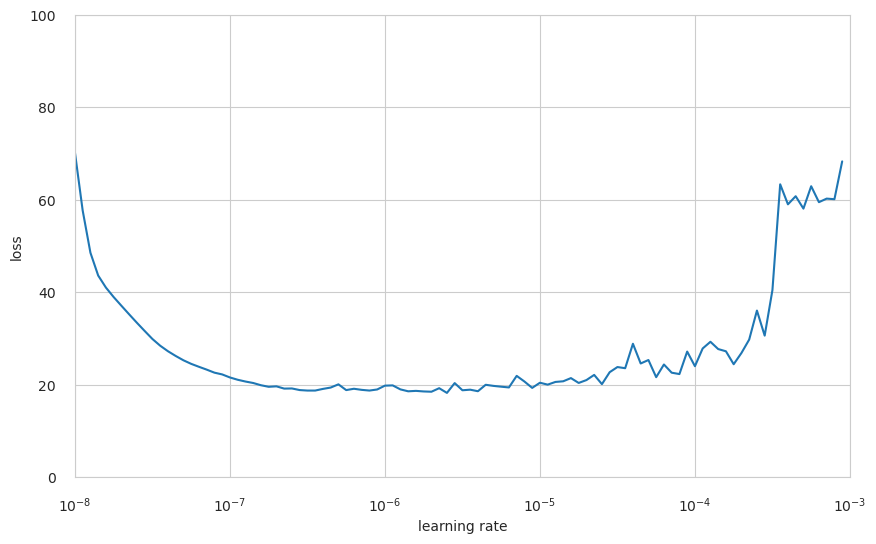

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [12]:
# Reset states generated by Keras
backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [13]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 46.7595 - mae: 47.2575
Epoch 2/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.0565 - mae: 23.5536

2024-06-14 14:16:54.736580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:54.736612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.3287 - mae: 23.8247
Epoch 3/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.5717 - mae: 19.0627

2024-06-14 14:16:55.191749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:55.191797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.9010 - mae: 20.3939
Epoch 4/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.8877 - mae: 19.3816

2024-06-14 14:16:55.652146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:55.652195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4304 - mae: 19.9236
Epoch 5/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1759 - mae: 19.6671

2024-06-14 14:16:56.105167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:56.105193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.2446 - mae: 19.7363
Epoch 6/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.8460 - mae: 18.3338

2024-06-14 14:16:56.549706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:56.549733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6983 - mae: 19.1897
Epoch 7/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4036 - mae: 18.8970

2024-06-14 14:16:57.022067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:57.022093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6016 - mae: 19.0938
Epoch 8/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6459 - mae: 19.1358

2024-06-14 14:16:57.473926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:57.473955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6651 - mae: 19.1564
Epoch 9/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7667 - mae: 18.2583

2024-06-14 14:16:57.927616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:57.927657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4647 - mae: 18.9568
Epoch 10/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.0653 - mae: 20.5568

2024-06-14 14:16:58.374226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:58.374258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.7056 - mae: 20.1983
Epoch 11/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5247 - mae: 17.0144

2024-06-14 14:16:58.827967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:58.828004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5404 - mae: 18.0311
Epoch 12/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3547 - mae: 17.8432

2024-06-14 14:16:59.284073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:59.284097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 17.9929 - mae: 18.4833
Epoch 13/100
21/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.2652 - mae: 18.7612

2024-06-14 14:16:59.788063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:16:59.788099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 18.3431 - mae: 18.8367
Epoch 14/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5773 - mae: 18.0721

2024-06-14 14:17:00.294348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:00.294381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.9092 - mae: 18.4029
Epoch 15/100
23/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.3113 - mae: 19.8045

2024-06-14 14:17:00.747730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:00.747763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.5966 - mae: 19.0893
Epoch 16/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7336 - mae: 18.2299

2024-06-14 14:17:01.229560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:01.229582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6840 - mae: 19.1789
Epoch 17/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4688 - mae: 18.9641

2024-06-14 14:17:01.676401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:01.676433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.9744 - mae: 18.4678
Epoch 18/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.2049 - mae: 17.6970

2024-06-14 14:17:02.124630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:02.124658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.1148 - mae: 18.6064
Epoch 19/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.9670 - mae: 18.4583

2024-06-14 14:17:02.602489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:02.602518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7632 - mae: 18.2553
Epoch 20/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7500 - mae: 17.2424

2024-06-14 14:17:03.050665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:03.050707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3661 - mae: 17.8593
Epoch 21/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.8247 - mae: 18.3136

2024-06-14 14:17:03.500700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:03.500728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.8302 - mae: 18.3205
Epoch 22/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6103 - mae: 17.1044

2024-06-14 14:17:03.967585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:03.967636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1437 - mae: 17.6366
Epoch 23/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7828 - mae: 18.2731

2024-06-14 14:17:04.435614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:04.435638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7379 - mae: 18.2288
Epoch 24/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.5105 - mae: 19.0031

2024-06-14 14:17:04.888013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:04.888061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.7253 - mae: 18.2169
Epoch 25/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0023 - mae: 17.4939

2024-06-14 14:17:05.370090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:05.370135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5841 - mae: 18.0764
Epoch 26/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.6542 - mae: 16.1426

2024-06-14 14:17:05.824392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:05.824439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9684 - mae: 17.4589
Epoch 27/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2132 - mae: 17.7002

2024-06-14 14:17:06.282827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:06.282851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5053 - mae: 17.9947
Epoch 28/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5556 - mae: 17.0501

2024-06-14 14:17:06.721023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:06.721050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3939 - mae: 17.8859
Epoch 29/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8542 - mae: 17.3469

2024-06-14 14:17:07.185013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:07.185052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1971 - mae: 17.6883
Epoch 30/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.0550 - mae: 18.5494

2024-06-14 14:17:07.646498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:07.646551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.1743 - mae: 18.6669
Epoch 31/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5563 - mae: 18.0444

2024-06-14 14:17:08.130025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:08.130058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4904 - mae: 17.9812
Epoch 32/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.5696 - mae: 17.0561

2024-06-14 14:17:08.574499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:08.574528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2928 - mae: 17.7818
Epoch 33/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7066 - mae: 18.1983

2024-06-14 14:17:09.046202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:09.046228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4646 - mae: 17.9561
Epoch 34/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.9343 - mae: 16.4303

2024-06-14 14:17:09.491034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:09.491081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7228 - mae: 17.2173
Epoch 35/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5707 - mae: 18.0633

2024-06-14 14:17:09.934227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:09.934283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.8482 - mae: 18.3401
Epoch 36/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.8419 - mae: 19.3344

2024-06-14 14:17:10.407631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:10.407667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7857 - mae: 18.2771
Epoch 37/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3801 - mae: 17.8711

2024-06-14 14:17:10.859517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:10.859559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2989 - mae: 17.7896
Epoch 38/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4349 - mae: 16.9222

2024-06-14 14:17:11.320846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:11.320871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0349 - mae: 17.5234
Epoch 39/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5598 - mae: 17.0508

2024-06-14 14:17:11.773677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:11.773707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9196 - mae: 17.4106
Epoch 40/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5226 - mae: 18.0135

2024-06-14 14:17:12.217397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:12.217429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6139 - mae: 18.1045
Epoch 41/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.2055 - mae: 17.7016

2024-06-14 14:17:12.669022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:12.669044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.4245 - mae: 17.9174
Epoch 42/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0240 - mae: 16.5116

2024-06-14 14:17:13.148978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:13.149009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9792 - mae: 17.4691
Epoch 43/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.3301 - mae: 16.8221

2024-06-14 14:17:13.600849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:13.600882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1376 - mae: 17.6292
Epoch 44/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7589 - mae: 17.2449

2024-06-14 14:17:14.073864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:14.073895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8374 - mae: 17.3257
Epoch 45/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8524 - mae: 17.3420

2024-06-14 14:17:14.520772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:14.520796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3594 - mae: 17.8498
Epoch 46/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9677 - mae: 17.4586

2024-06-14 14:17:14.972418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:14.972447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.3280 - mae: 17.8187
Epoch 47/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5255 - mae: 17.0157

2024-06-14 14:17:15.450917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:15.450955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0774 - mae: 17.5667
Epoch 48/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0577 - mae: 16.5518

2024-06-14 14:17:15.908504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:15.908534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9398 - mae: 17.4327
Epoch 49/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3954 - mae: 17.8841

2024-06-14 14:17:16.358624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:16.358645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1614 - mae: 17.6506
Epoch 50/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0600 - mae: 18.5495

2024-06-14 14:17:16.807790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:16.807828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7577 - mae: 18.2486
Epoch 51/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.9441 - mae: 16.4332

2024-06-14 14:17:17.258056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:17.258083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5553 - mae: 17.0459
Epoch 52/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6085 - mae: 18.0983

2024-06-14 14:17:17.712452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:17.712495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5111 - mae: 18.0022
Epoch 53/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3855 - mae: 16.8755

2024-06-14 14:17:18.185322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:18.185361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8518 - mae: 17.3423
Epoch 54/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.7405 - mae: 17.2307

2024-06-14 14:17:18.645388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:18.645414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9848 - mae: 17.4749
Epoch 55/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1506 - mae: 17.6439

2024-06-14 14:17:19.107786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:19.107816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3605 - mae: 17.8509
Epoch 56/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5355 - mae: 17.0283

2024-06-14 14:17:19.555197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:19.555239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9585 - mae: 17.4502
Epoch 57/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3932 - mae: 16.8855

2024-06-14 14:17:20.008851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:20.008876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.9276 - mae: 17.4204
Epoch 58/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7728 - mae: 18.2676

2024-06-14 14:17:20.490046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:20.490075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6479 - mae: 18.1411
Epoch 59/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6411 - mae: 17.1289

2024-06-14 14:17:20.953586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:20.953609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9712 - mae: 17.4602
Epoch 60/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1932 - mae: 17.6833

2024-06-14 14:17:21.407166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:21.407192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9805 - mae: 17.4708
Epoch 61/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4778 - mae: 16.9660

2024-06-14 14:17:21.859195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:21.859222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6168 - mae: 17.1050
Epoch 62/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4415 - mae: 16.9343

2024-06-14 14:17:22.304869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:22.304901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4199 - mae: 17.9130
Epoch 63/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1020 - mae: 17.5906

2024-06-14 14:17:22.755234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:22.755264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.2266 - mae: 17.7162
Epoch 64/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1082 - mae: 16.5978

2024-06-14 14:17:23.237163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:23.237188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7792 - mae: 17.2693
Epoch 65/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.8207 - mae: 17.3127

2024-06-14 14:17:23.686095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:23.686122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2166 - mae: 17.7076
Epoch 66/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6727 - mae: 17.1652

2024-06-14 14:17:24.157794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:24.157819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8114 - mae: 17.3026
Epoch 67/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4834 - mae: 17.9745

2024-06-14 14:17:24.608008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:24.608058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3367 - mae: 17.8276
Epoch 68/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6271 - mae: 17.1156

2024-06-14 14:17:25.059413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:25.059449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9513 - mae: 17.4409
Epoch 69/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8815 - mae: 17.3730

2024-06-14 14:17:25.515637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:25.515659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.9368 - mae: 17.4291
Epoch 70/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7606 - mae: 17.2530

2024-06-14 14:17:25.996386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:25.996417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8802 - mae: 17.3712
Epoch 71/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9423 - mae: 17.4326

2024-06-14 14:17:26.438367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:26.438394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1884 - mae: 17.6789
Epoch 72/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2250 - mae: 16.7152

2024-06-14 14:17:26.892845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:26.892869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8480 - mae: 17.3376
Epoch 73/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6622 - mae: 17.1505

2024-06-14 14:17:27.344609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:27.344643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9061 - mae: 17.3959
Epoch 74/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2726 - mae: 16.7633

2024-06-14 14:17:27.801115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:27.801141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.3143 - mae: 17.8047
Epoch 75/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1458 - mae: 17.6361

2024-06-14 14:17:28.281759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:28.281788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2268 - mae: 17.7171
Epoch 76/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4925 - mae: 17.9819

2024-06-14 14:17:28.735157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:28.735198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4481 - mae: 17.9383
Epoch 77/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9069 - mae: 17.3972

2024-06-14 14:17:29.220135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:29.220160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9120 - mae: 17.4021
Epoch 78/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2645 - mae: 18.7572

2024-06-14 14:17:29.667081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:29.667104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3637 - mae: 17.8553
Epoch 79/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.9677 - mae: 16.4569

2024-06-14 14:17:30.126684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:30.126713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5462 - mae: 17.0354
Epoch 80/100
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2134 - mae: 17.6967

2024-06-14 14:17:30.580282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:30.580327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.3503 - mae: 17.8364
Epoch 81/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7157 - mae: 18.2074

2024-06-14 14:17:31.073193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:31.073237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4932 - mae: 17.9830
Epoch 82/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0733 - mae: 17.5649

2024-06-14 14:17:31.534586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:31.534614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8414 - mae: 17.3322
Epoch 83/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0362 - mae: 17.5255

2024-06-14 14:17:31.995757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:31.995799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8190 - mae: 17.3071
Epoch 84/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5592 - mae: 17.0519

2024-06-14 14:17:32.456998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:32.457023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7334 - mae: 17.2251
Epoch 85/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9394 - mae: 17.4300

2024-06-14 14:17:32.908448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:32.908472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1466 - mae: 17.6363
Epoch 86/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.9100 - mae: 18.3983

2024-06-14 14:17:33.378553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:33.378574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5383 - mae: 18.0279
Epoch 87/100
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4930 - mae: 15.9808

2024-06-14 14:17:33.834691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:33.834720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4622 - mae: 16.9498
Epoch 88/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4428 - mae: 15.9358

2024-06-14 14:17:34.297658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:34.297680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5900 - mae: 17.0820
Epoch 89/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7121 - mae: 17.2059

2024-06-14 14:17:34.752690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:34.752717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9028 - mae: 17.3951
Epoch 90/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1096 - mae: 17.5945

2024-06-14 14:17:35.208979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:35.209003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0863 - mae: 17.5737
Epoch 91/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.1579 - mae: 17.6518

2024-06-14 14:17:35.647306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:35.647336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.3188 - mae: 17.8097
Epoch 92/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6037 - mae: 19.0929

2024-06-14 14:17:36.133697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:36.133735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4769 - mae: 17.9667
Epoch 93/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1205 - mae: 17.6070

2024-06-14 14:17:36.588756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:36.588804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3805 - mae: 17.8698
Epoch 94/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8863 - mae: 17.3765

2024-06-14 14:17:37.038076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:37.038121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.9339 - mae: 17.4243
Epoch 95/100
23/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.9986 - mae: 16.4921

2024-06-14 14:17:37.522006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:37.522055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.5594 - mae: 17.0515
Epoch 96/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5144 - mae: 17.0048

2024-06-14 14:17:38.016215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:38.016265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.8980 - mae: 17.3876
Epoch 97/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2218 - mae: 17.7110

2024-06-14 14:17:38.506567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:38.506592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0065 - mae: 17.4952
Epoch 98/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7203 - mae: 17.2116

2024-06-14 14:17:38.974009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:38.974036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7468 - mae: 17.2365
Epoch 99/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6101 - mae: 18.0962

2024-06-14 14:17:39.439366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:39.439390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0137 - mae: 17.5010
Epoch 100/100
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5691 - mae: 18.0611

2024-06-14 14:17:39.897265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:39.897294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0157 - mae: 17.5073


2024-06-14 14:17:40.349206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:40.349258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


You can visualize the training and see if the loss and MAE are still trending down.

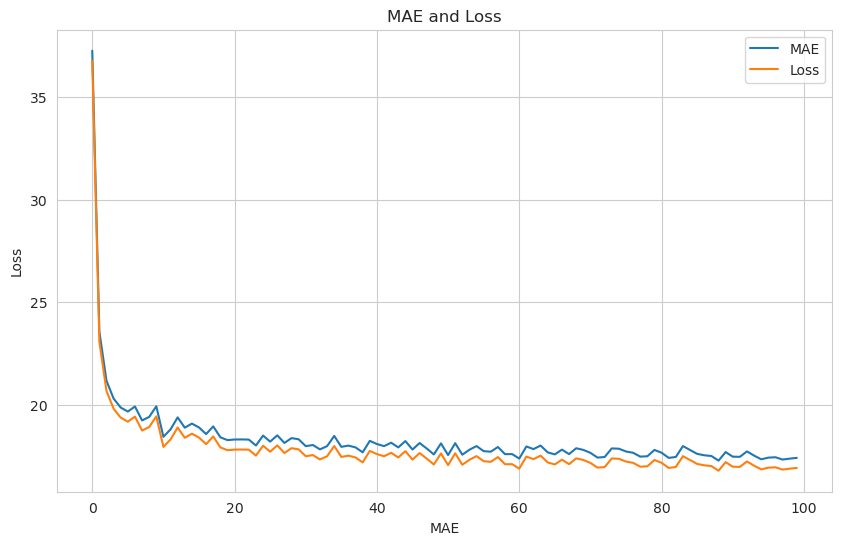

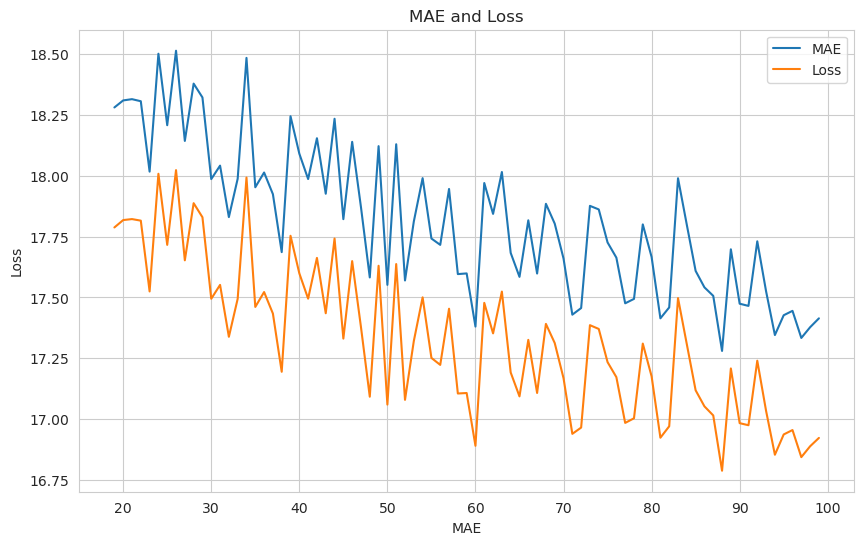

In [15]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plot_series(x=epochs, y=(mae, loss), title='MAE and Loss', xlabel='MAE', ylabel='Loss', legend=['MAE', 'Loss'])

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(x=epochs_zoom, y=(mae_zoom, loss_zoom), title='MAE and Loss', xlabel='MAE', ylabel='Loss', legend=['MAE', 'Loss'])

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-06-14 14:17:41.125009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


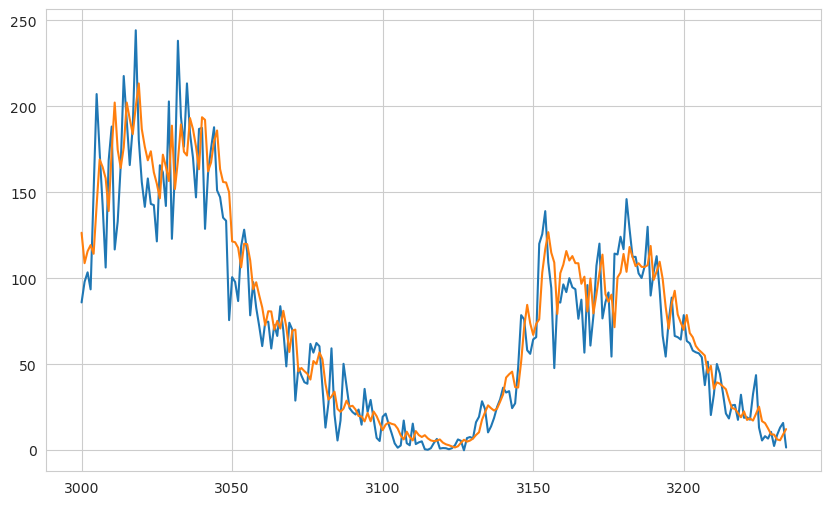

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [18]:
# Compute the MAE
print(metrics.mean_absolute_error(x_valid, results).numpy())

15.102164


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!

## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.

In [19]:
# Initialize the optimizer
optimizer = optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=10)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16.9928 - mae: 17.4844
Epoch 2/10
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0182 - mae: 17.5081

2024-06-14 14:17:42.903481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:42.903516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4949 - mae: 16.9846
Epoch 3/10
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3015 - mae: 15.7912

2024-06-14 14:17:43.355914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:43.355938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 14:17:43.355953: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10703239565999506502


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8667 - mae: 16.3563
Epoch 4/10
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2883 - mae: 16.7767

2024-06-14 14:17:43.814790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:43.814814: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10703239565999506502
2024-06-14 14:17:43.814823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 14:17:43.814841: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7143062992325326269


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5951 - mae: 17.0846
Epoch 5/10
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8094 - mae: 16.2973

2024-06-14 14:17:44.270576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 14:17:44.270603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:44.270618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10703239565999506502


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2401 - mae: 16.7289
Epoch 6/10
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.5198 - mae: 15.0072

2024-06-14 14:17:44.719781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:44.719809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:17:44.719827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7143062992325326269
2024-06-14 14:17:44.719834: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10703239565999506502


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.9090 - mae: 16.3982
Epoch 7/10
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0812 - mae: 16.5657

2024-06-14 14:17:45.202352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:45.202381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:17:45.202394: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7143062992325326269
2024-06-14 14:17:45.202403: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10703239565999506502


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1784 - mae: 16.6650
Epoch 8/10
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0310 - mae: 17.5156

2024-06-14 14:17:45.661398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:45.661425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 14:17:45.661440: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10703239565999506502


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7260 - mae: 17.2130
Epoch 9/10
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2637 - mae: 16.7454

2024-06-14 14:17:46.106539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:46.106567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 14:17:46.106583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10703239565999506502


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4340 - mae: 16.9190
Epoch 10/10
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8006 - mae: 16.2900

2024-06-14 14:17:46.552618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:46.552645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0859 - mae: 16.5749


2024-06-14 14:17:47.009032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:47.009056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [20]:
# Set the initial learning rate
initial_learning_rate = 1e-7

# Define the scheduler
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=400, decay_rate=0.96, staircase=True)

# Set the optimizer
optimizer = optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16.3629 - mae: 16.8500
Epoch 2/40
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.9850 - mae: 15.4734

2024-06-14 14:17:48.939479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:48.939525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.7516 - mae: 16.2417
Epoch 3/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5614 - mae: 17.0475

2024-06-14 14:17:49.421785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:49.421822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2923 - mae: 16.7790
Epoch 4/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.9855 - mae: 16.4662

2024-06-14 14:17:49.891163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:49.891189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1976 - mae: 16.6828
Epoch 5/40
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4683 - mae: 15.9552

2024-06-14 14:17:50.350983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:50.351013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8953 - mae: 16.3828
Epoch 6/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.0785 - mae: 15.5631

2024-06-14 14:17:50.814699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:50.814724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.7612 - mae: 16.2478
Epoch 7/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2205 - mae: 16.7120

2024-06-14 14:17:51.267895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:51.267934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2584 - mae: 16.7481
Epoch 8/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.9381 - mae: 16.4273

2024-06-14 14:17:51.748632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:51.748654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3143 - mae: 16.8037
Epoch 9/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4023 - mae: 16.8935

2024-06-14 14:17:52.198483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:52.198517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3318 - mae: 16.8221
Epoch 10/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6313 - mae: 18.1220

2024-06-14 14:17:52.655918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:52.655943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8673 - mae: 17.3577
Epoch 11/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0862 - mae: 17.5751

2024-06-14 14:17:53.110475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:53.110518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6633 - mae: 17.1522
Epoch 12/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3264 - mae: 15.8121

2024-06-14 14:17:53.564982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:53.565025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8952 - mae: 16.3821
Epoch 13/40
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2043 - mae: 17.6913

2024-06-14 14:17:54.065024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:54.065047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7158 - mae: 17.2034
Epoch 14/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2193 - mae: 16.7016

2024-06-14 14:17:54.522113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:54.522150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2203 - mae: 16.7066
Epoch 15/40
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1344 - mae: 17.6212

2024-06-14 14:17:54.981937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:54.981966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5039 - mae: 16.9912
Epoch 16/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0407 - mae: 16.5257

2024-06-14 14:17:55.435389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:55.435413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1182 - mae: 16.6044
Epoch 17/40
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.0471 - mae: 17.5339

2024-06-14 14:17:55.892985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:55.893008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5744 - mae: 17.0639
Epoch 18/40
22/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.6158 - mae: 16.1068

2024-06-14 14:17:56.323359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:56.323393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.0788 - mae: 16.5685
Epoch 19/40
24/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3048 - mae: 16.7932

2024-06-14 14:17:56.820376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:56.820408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1362 - mae: 16.6225
Epoch 20/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4362 - mae: 15.9233

2024-06-14 14:17:57.280490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:57.280513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8484 - mae: 16.3360
Epoch 21/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5906 - mae: 17.0792

2024-06-14 14:17:57.729930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:57.729955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4323 - mae: 16.9212
Epoch 22/40
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.5251 - mae: 16.0061

2024-06-14 14:17:58.174199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:58.174219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8020 - mae: 16.2875
Epoch 23/40
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0680 - mae: 16.5482

2024-06-14 14:17:58.593952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:58.593976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2939 - mae: 16.7793
Epoch 24/40
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3106 - mae: 17.7965

2024-06-14 14:17:59.022627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:59.022652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6567 - mae: 17.1436
Epoch 25/40
28/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0473 - mae: 16.5307

2024-06-14 14:17:59.470758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:59.470786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1640 - mae: 16.6502
Epoch 26/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4069 - mae: 17.8902

2024-06-14 14:17:59.893689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:17:59.893716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7840 - mae: 17.2718
Epoch 27/40
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0696 - mae: 16.5586

2024-06-14 14:18:00.342178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:00.342207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3428 - mae: 16.8316
Epoch 28/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.2179 - mae: 17.7098

2024-06-14 14:18:00.787820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:00.787845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7262 - mae: 17.2162
Epoch 29/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1730 - mae: 16.6561

2024-06-14 14:18:01.242087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:01.242120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1572 - mae: 16.6433
Epoch 30/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1778 - mae: 17.6685

2024-06-14 14:18:01.691629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:01.691692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 14:18:01.691710: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4451532844635988489
2024-06-14 14:18:01.691755: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4970080815976626638
2024-06-14 14:18:01.691773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7893932466019284378


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.5956 - mae: 17.0862
Epoch 31/40
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.7563 - mae: 16.2407

2024-06-14 14:18:02.176361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:02.176392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1067 - mae: 16.5933
Epoch 32/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3940 - mae: 17.8819

2024-06-14 14:18:02.631015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:02.631058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7637 - mae: 17.2521
Epoch 33/40
26/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.6726 - mae: 16.1591

2024-06-14 14:18:03.098072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:03.098115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1512 - mae: 16.6385
Epoch 34/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.1330 - mae: 15.6196

2024-06-14 14:18:03.547371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:03.547393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8114 - mae: 16.3003
Epoch 35/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0519 - mae: 16.5404

2024-06-14 14:18:04.024120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:04.024141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3466 - mae: 16.8359
Epoch 36/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7427 - mae: 17.2259

2024-06-14 14:18:04.480643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:04.480665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3982 - mae: 16.8849
Epoch 37/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.4864 - mae: 15.9711

2024-06-14 14:18:04.965081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:04.965116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.9617 - mae: 16.4483
Epoch 38/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.6905 - mae: 16.1793

2024-06-14 14:18:05.431536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:05.431559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0167 - mae: 16.5050
Epoch 39/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.6561 - mae: 16.1395

2024-06-14 14:18:05.879719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:05.879739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1154 - mae: 16.6016
Epoch 40/40
25/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0742 - mae: 16.5570

2024-06-14 14:18:06.338743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:06.338782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2314 - mae: 16.7176


2024-06-14 14:18:06.791020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:18:06.791063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Now see the results by geting predicitons and computing the metrics.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-06-14 14:18:07.136158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


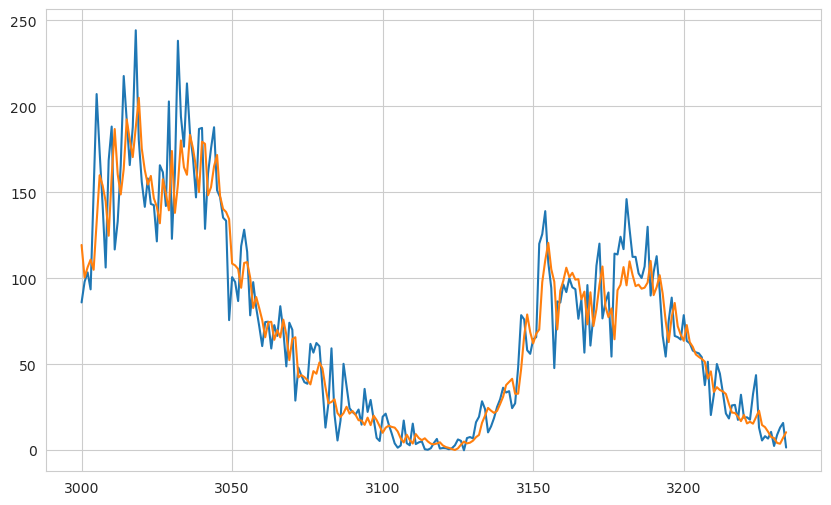

In [21]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [22]:
# Compute the MAE
metrics.mean_absolute_error(x_valid, results).numpy()

14.309738

In [23]:
!rm *.csv